In [27]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances_argmin

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

from kmodes.kmodes import KModes

### Discovering structure in the data
It is uncertain if the symptoms present are all due to the same disease, or if they are different conditions with similar symptoms. (a) looking at only the attributes, estimate whether a single-cluster model is more likely than a multiple-cluster model. You can use anything, starting from a simple clustering algorithm like k-means to a hierarchical Bayesian model. (b) Try and determine whether some particular factors are important for disease epidemiology and may require further investigations.

In [28]:
# Read the data
features = pd.read_csv('./medical/historical_X.dat', header=None, sep=" ").values
actions = pd.read_csv('./medical/historical_A.dat', header=None, sep=" ").values
outcome = pd.read_csv('./medical/historical_Y.dat', header=None, sep=" ").values
observations = features[:, :128]
labels = features[:,128] + features[:,129]*2

In [29]:
symptoms = np.append(observations, labels[:,None], 1)

In [30]:
symptoms_true = symptoms[np.where(symptoms[:,128] != 0)]
symptoms_false = symptoms[np.where(symptoms[:,128] == 0)]

print(symptoms_true.shape)
print(symptoms_false.shape)

(5168, 129)
(4832, 129)


We want the dendrogram of the observations data only.

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Dendrogram observation data")
dend = shc.dendrogram(shc.linkage(observations, method='ward'))
plt.savefig('Images/dendrogram_observations')
plt.show()

We can also have a look at the elbow plot. We use KModes here instead of KMeans, which is suited for categorical data. The 'Cao' method uses an intitialization based on density.

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

model = KModes(init='Cao', n_init = 1, n_jobs=-1)
visualizer = KElbowVisualizer(model, k=(2,10), timings = False, locate_elbow = False)
visualizer.fit(observations)        # Fit the data to the visualizer
visualizer.show(outpath = "Images/kelbow_kmodes.png")

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 631180.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 534, cost: 483164.0
Run 1, iteration: 2/100, moves: 404, cost: 482292.0
Run 1, iteration: 3/100, moves: 305, cost: 481822.0
Run 1, iteration: 4/100, moves: 211, cost: 481450.0
Run 1, iteration: 5/100, moves: 248, cost: 481186.0
Run 1, iteration: 6/100, moves: 88, cost: 481186.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1352, cost: 446008.0
Run 1, iteration: 2/100, moves: 934, cost: 442497.0
Run 1, iteration: 3/100, moves: 827, cost: 440755.0
Run 1, iteration: 4/100, moves: 410, cost: 440273.0
Run 1, iteration: 5/100, moves: 256, cost: 440023.0
Run 1, iteration: 6/100, moves: 131, cost: 439975.0
Run 1, iteration: 7/100, moves: 29, cost: 439975.0
Init: initializing centroids
Init: 

ValueError: x and y must have same first dimension, but have shapes (14,) and (9,)

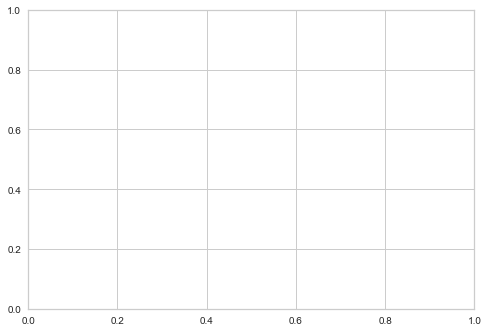

In [6]:
cost = []
for num_clusters in list(range(1,10)):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(observations)
    cost.append(kmode.cost_)

y = np.array([i for i in range(1,15,1)])
plt.plot(y,cost)
plt.xlabel('Clusters')
plt.ylabel('Cost')
plt.show()

In [31]:
k = 4

In [32]:
def find_clusters(X, n_clusters, rseed = 2):
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    while True:
        labels = pairwise_distances_argmin(X, centers)
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])

        if np.all(centers == new_centers):
            break
        centers = new_centers

    return centers, labels

In [33]:
centers, k_clusters = find_clusters(observations, k)

k_clusters

array([3, 0, 2, ..., 1, 0, 3])

In [34]:
km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=1)

clusters = km.fit_predict(observations)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1725, cost: 424311.0
Run 1, iteration: 2/100, moves: 1077, cost: 421030.0
Run 1, iteration: 3/100, moves: 951, cost: 417570.0
Run 1, iteration: 4/100, moves: 815, cost: 416113.0
Run 1, iteration: 5/100, moves: 474, cost: 415286.0
Run 1, iteration: 6/100, moves: 322, cost: 414782.0
Run 1, iteration: 7/100, moves: 301, cost: 414685.0
Run 1, iteration: 8/100, moves: 6, cost: 414685.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 2052, cost: 421869.0
Run 2, iteration: 2/100, moves: 936, cost: 419828.0
Run 2, iteration: 3/100, moves: 612, cost: 417919.0
Run 2, iteration: 4/100, moves: 548, cost: 416752.0
Run 2, iteration: 5/100, moves: 345, cost: 416548.0
Run 2, iteration: 6/100, moves: 4, cost: 416548.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 2

In [35]:
clusters

array([2, 3, 0, ..., 1, 0, 3], dtype=uint16)

In [9]:
obs_clusters_kmeans = np.append(observations, clusters[:,None], 1)

In [10]:
obs_clusters_kmeans = np.append(obs_clusters_kmeans, labels[:,None], 1)

In [11]:
obs_clusters_kmeans.shape

# last column (130) is labels
# 129 is clusters 

(10000, 130)

In [12]:
symptoms_true_k = obs_clusters_kmeans[np.where(obs_clusters_kmeans[:,129] != 0)]
symptoms_false_k = obs_clusters_kmeans[np.where(obs_clusters_kmeans[:,129] == 0)]

In [13]:
clusters_no_symp_k = symptoms_false_k[:,128]
clusters_symp_k = symptoms_true_k[:,128]

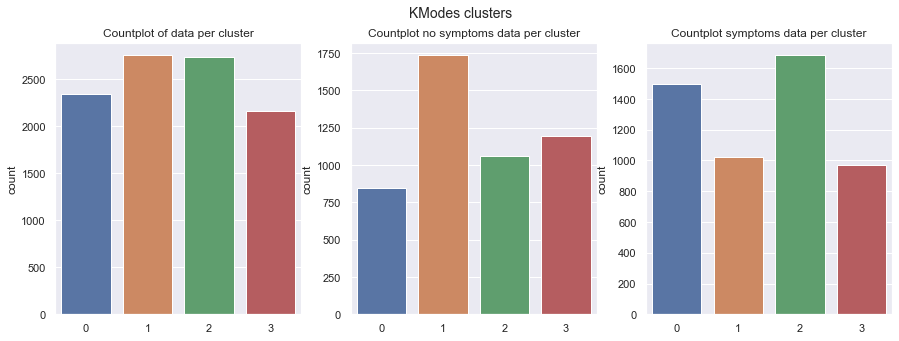

In [14]:
fig1, ax = plt.subplots(figsize = (15, 5), ncols = 3)
sns.countplot(clusters, ax = ax[0])
sns.countplot(clusters_no_symp_k, ax = ax[1])
sns.countplot(clusters_symp_k, ax = ax[2])

fig1.suptitle("KModes clusters", fontsize=14)
ax[0].set_title('Countplot of data per cluster')
ax[1].set_title('Countplot no symptoms data per cluster')
ax[2].set_title('Countplot symptoms data per cluster')


plt.show()

In [15]:
k = 3

In [16]:
obs_symp_true = symptoms_true[:,:128]
labels_symp_true = symptoms_true[:,128]

centers_symp, k_clusters_symp = find_clusters(obs_symp_true, k)
symp_clusters = np.append(obs_symp_true, k_clusters_symp[:,None], 1)
symp_clusters = np.append(symp_clusters, labels_symp_true[:,None], 1)

NameError: name 'find_clusters' is not defined

In [17]:
km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=1)

clus = km.fit_predict(obs_symp_true)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1051, cost: 228563.0
Run 1, iteration: 2/100, moves: 850, cost: 224046.0
Run 1, iteration: 3/100, moves: 668, cost: 221105.0
Run 1, iteration: 4/100, moves: 309, cost: 220660.0
Run 1, iteration: 5/100, moves: 119, cost: 220570.0
Run 1, iteration: 6/100, moves: 72, cost: 220494.0
Run 1, iteration: 7/100, moves: 83, cost: 220398.0
Run 1, iteration: 8/100, moves: 119, cost: 220304.0
Run 1, iteration: 9/100, moves: 41, cost: 220304.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1268, cost: 230536.0
Run 2, iteration: 2/100, moves: 720, cost: 226094.0
Run 2, iteration: 3/100, moves: 503, cost: 224648.0
Run 2, iteration: 4/100, moves: 120, cost: 224648.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 822, cost: 220555.0
Run 3, iteration: 2/100, moves: 3

In [18]:
symp_clusters = np.append(obs_symp_true, clus[:,None], 1)
symp_clusters = np.append(symp_clusters, labels_symp_true[:,None], 1)

In [19]:
# symp_clusters[:,129] zijn de symptomen, 
# symp_clusters[:,128] de clusters

In [20]:
symptom_a = symp_clusters[np.where(symp_clusters[:,129] == 1)]
symptom_b = symp_clusters[np.where(symp_clusters[:,129] == 2)]
symptom_both = symp_clusters[np.where(symp_clusters[:,129] == 3)]

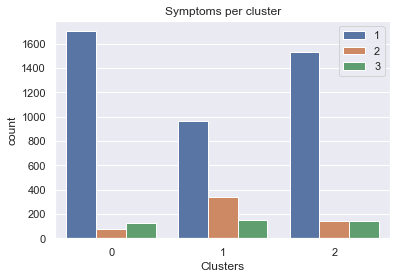

In [21]:
g = sns.countplot(x = symp_clusters[:,128], hue = symp_clusters[:,129])
plt.title('Symptoms per cluster')
plt.xlabel('Clusters')
    
plt.show()

In [40]:
# target = labels 
# data = observations

In [41]:
data = np.append(observations, labels[:,None], 1)
data.shape

#target = data[:,128]

(10000, 129)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate, KFold

In [54]:
clf = RandomForestClassifier(n_estimators=130, random_state=0)
clf.fit(data[:,:128], data[:,128])

#clf_cv = cross_validate(clf, data[:,:128], data[:,128], cv = 5, return_estimator = True)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=130,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [74]:
k = 10
kf = KFold(n_splits=k, shuffle = True)
rfc = RandomForestClassifier()
count = 1

X = data[:,:128]
y = data[:,128]

imp_sorted_ = {}
for train, _ in kf.split(X, y):
    rfc.fit(X[train, :], y[train])
    
    for key, value in enumerate(rfc.feature_importances_):    
        imp_sorted_[key] = imp_sorted_.get(key, 0) + value

feature_imp = pd.DataFrame.from_dict(imp_sorted_, orient = 'index', columns = ['avg_imp'])
feature_imp['avg_imp'] = feature_imp['avg_imp']/10
feature_imp.sort_values(by = 'avg_imp', ascending = False).head()

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,avg_imp
5,0.070210
3,0.049257
113,0.029684
11,0.017977
52,0.014964


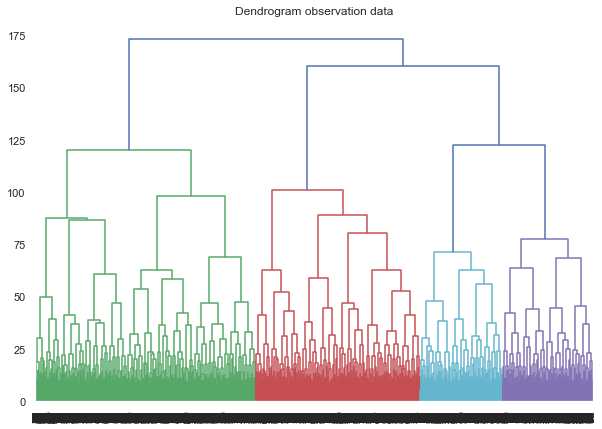

In [24]:
plt.figure(figsize=(10, 7))
plt.title("Dendrogram observation data")
dend = shc.dendrogram(shc.linkage(observations, method='ward'))
plt.show()

### WITH PCA 

In [25]:
from sklearn.decomposition import PCA

pca = PCA(.50)
data_red = pca.fit_transform(observations)
print(pca.n_components_)

6


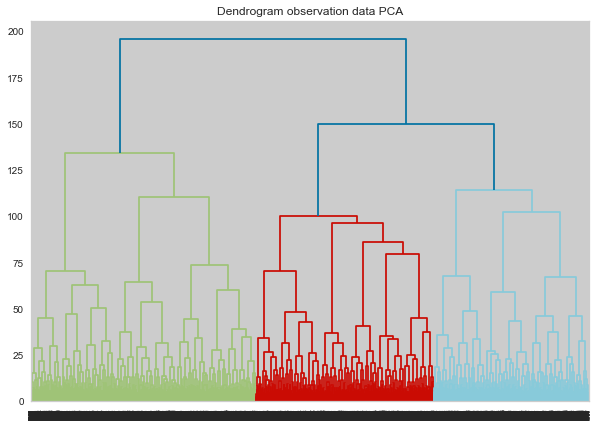

In [29]:
plt.figure(figsize=(10, 7))
plt.title("Dendrogram observation data PCA")
dend = shc.dendrogram(shc.linkage(data_red, method='ward'))
plt.show()

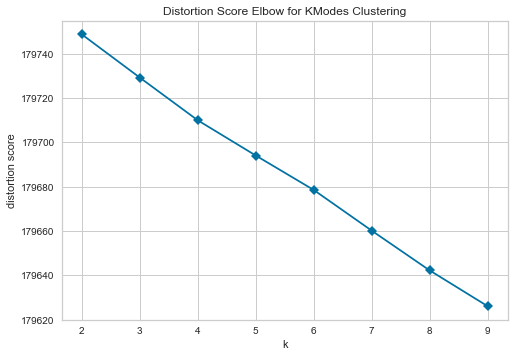

In [30]:
model = KModes(init='Cao', n_init = 1, n_jobs=-1)
visualizer = KElbowVisualizer(model, k=(2,10), timings = False, locate_elbow = False)
visualizer.fit(data_red)        # Fit the data to the visualizer
visualizer.show()

### Measuring the effect of actions.
We also observe the effects of two different therapeutic interventions, one of which is placebo, and the other is an experimental drug. Try and measure
the effectiveness of the placebo versus the active treatment. Are there perhaps cases where the
active treatment is never effective, or should it always be recommended?

In [35]:
features = pd.read_csv('./medical/historical_X.dat', header=None, sep=" ").values
actions = pd.read_csv('./medical/historical_A.dat', header=None, sep=" ").values
outcome = pd.read_csv('./medical/historical_Y.dat', header=None, sep=" ").values
observations = features[:, :128]
labels = features[:,128] + features[:,129]*2

In [36]:
#Effectiveness of the placebo.
rangefeatures = range(len(features))
counter = 0
placebofeatures = []

for i in rangefeatures:
    if labels[i] != 0 and actions[i] == 0 and outcome[i] == 1: # we don't give treatment and the patient is cured
        placebofeatures.append(features[i])

print(len(placebofeatures))
print("Effectiveness : {}%".format((len(placebofeatures)/len(features))*100))

39
Effectiveness : 0.38999999999999996%


In [37]:
#Effectiveness of the placebo.
rangefeatures = range(len(features))
counter = 0
placebofeatures = []

for i in rangefeatures:
    if labels[i] != 0 and actions[i] == 0 and outcome[i] == 0: # we don't give treatment and the patient is cured
        placebofeatures.append(features[i])

print(len(placebofeatures))
print("Effectiveness : {}%".format((len(placebofeatures)/len(features))*100))

2831
Effectiveness : 28.310000000000002%


In [38]:
#Effectiveness of the placebo.
rangefeatures = range(len(features))
counter = 0
placebofeatures = []

for i in rangefeatures:
    if  actions[i] == 0 and outcome[i] == 1: # we don't give treatment and the patient is cured
        placebofeatures.append(features[i])

print(len(placebofeatures))
print("Effectiveness : {}%".format((len(placebofeatures)/len(features))*100))

69
Effectiveness : 0.69%


In [39]:
#Effectiveness of the active treatment.
rangefeatures = range(len(features))
ExperimentalDrugFeaturesSuccess = []

for i in rangefeatures:
    if labels[i] != 0 and actions[i] == 1 and outcome[i] == 1: # we give treatment and the patient is cured
        ExperimentalDrugFeaturesSuccess.append(features[i])

        

print(len(ExperimentalDrugFeaturesSuccess))
print("Effectiveness : {}%".format((len(ExperimentalDrugFeaturesSuccess)/len(features))*100))   

1352
Effectiveness : 13.52%


In [40]:
#Failure of the active treatment.
rangefeatures = range(len(features))
ExperimentalDrugFeaturesFailure = []

for i in rangefeatures:
    if labels[i] != 0 and actions[i] == 1 and outcome[i] == 0: # we give treatment and the patient isn't cured
        ExperimentalDrugFeaturesFailure.append(features[i])

        

print(len(ExperimentalDrugFeaturesFailure))    
print("Proportion : {}%".format((len(ExperimentalDrugFeaturesFailure)/len(features))*100))    

946
Proportion : 9.46%


In [41]:
#No treatment and the patient isn't cured.
rangefeatures = range(len(features))
NoTreatmentFailure = []

for i in rangefeatures:
    if actions[i] == 0 and outcome[i] == 0: # we don't give treatment and the patient isn't cured
        NoTreatmentFailure.append(features[i])

        

print(len(NoTreatmentFailure))

print("Proportion : {}%".format((len(NoTreatmentFailure)/len(features))*100))   

7633
Proportion : 76.33%
